# STAT207 Project 2: Predicting the Used Price of Video Games


Ryan Sponzilli

In [1]:
#Imports here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore scikit-learn ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Introduction

In this project, I will be using a dataset about video games. Each row in the dataset represents a distinct video game. This dataset was collected by Dr. Joe Cox, and the playtime information was collected from crowd-sourced data on "How Long to Beat." The primary research goal that I am pursuing is to build a predictive model that will effectively predict `used_price` for new datasets. According to the author of the dataset, `used_price` represents "A typical "used" price for this game (i.e. previously returned and sold), measured in dollars." The explanatory variables that will be considered in this analysis are `review_score`, `sales`, `average_length`, `console`, and `rating`. The secondary research goal that I am pursuing is for the chosen model to yield interpretive insights about the nature of the relationship between the variables in the dataset. The motivation for such a predictive model is to be able to accurately price a used video game for resale. For example, someone runs a small business selling used video games on eBay would find this model useful for finding out what a fair listing price is for a particular video game.

# 2. Dataset Discussion

### Dataset Display

This dataset has 1,212 rows in total.

In [2]:
df = pd.read_csv("video_games.csv")
df.head()

,Title,Features.Handheld?,Features.Max Players,Features.Multiplatform?,Features.Online?,Metadata.Genres,Metadata.Licensed?,Metadata.Publishers,Metadata.Sequel?,Metrics.Review Score,...,Length.Main + Extras.Average,Length.Main + Extras.Leisure,Length.Main + Extras.Median,Length.Main + Extras.Polled,Length.Main + Extras.Rushed,Length.Main Story.Average,Length.Main Story.Leisure,Length.Main Story.Median,Length.Main Story.Polled,Length.Main Story.Rushed
0,Super Mario 64 DS,True,1,True,True,Action,True,Nintendo,True,85,...,24.916667,29.966667,25.000000,16,18.333333,14.333333,18.316667,14.500000,21,9.700000
1,Lumines: Puzzle Fusion,True,1,True,True,Strategy,True,Ubisoft,True,89,...,9.750000,9.866667,9.750000,2,9.616667,10.333333,11.083333,10.000000,3,9.583333
2,WarioWare Touched!,True,2,True,True,"Action,Racing / Driving,Sports",True,Nintendo,True,81,...,3.850000,5.666667,3.333333,11,2.783333,1.916667,2.933333,1.833333,30,1.433333
3,Hot Shots Golf: Open Tee,True,1,True,True,Sports,True,Sony,True,81,...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000
4,Spider-Man 2,True,1,True,True,Action,True,Activision,True,61,...,12.766667,17.316667,12.500000,12,10.483333,8.350000,11.083333,8.000000,23,5.333333


In [3]:
df.shape

(1212, 36)

### Dataset Source 
I obtained this dataset from Dr. Ellison, and she originally downloaded the dataset at https://corgis-edu.github.io/corgis/csv/video_games/ on 9/8/2023.

# 3. Dataset Cleaning

I am going to only include the relevant columns to this analysis in the dataframe, and remove the rest. I am also going to rename the columns for convenience.

In [4]:
df = df[["Metrics.Review Score", "Metrics.Sales", "Metrics.Used Price", "Length.All PlayStyles.Average", "Release.Console", "Release.Rating"]]
df.rename(columns={"Title": "title","Metrics.Review Score": "review_score", "Metrics.Sales": "sales", "Metrics.Used Price": "used_price", "Release.Console": "console", "Release.Rating": "rating", "Length.All PlayStyles.Average": "average_length"}, inplace=True)
df.head()

,review_score,sales,used_price,average_length,console,rating
0,85,4.69,24.95,22.716667,Nintendo DS,E
1,89,0.56,14.95,10.100000,Sony PSP,E
2,81,0.54,22.95,4.566667,Nintendo DS,E
3,81,0.49,12.95,0.000000,Sony PSP,E
4,61,0.45,14.95,13.250000,Nintendo DS,E


### Missing Values
The variables in the reduced dataframe have no explicit missing values, and the datatypes are as expected which implies no implicit missing values.

In [5]:
# Look for explicit missing values
df.isna().sum()

review_score      0
sales             0
used_price        0
average_length    0
console           0
rating            0
dtype: int64

In [6]:
# Look for implicit missing values
df.dtypes

review_score        int64
sales             float64
used_price        float64
average_length    float64
console            object
rating             object
dtype: object

### Outlier Cleaning

I made boxplots for each numerical variable to gauge the distribution of outliers. I eliminated the 3 most extreme outliers from both `sales` and `average_length` since those outliers were very extreme and likely creating an extreme skew of the data. The tradeoff of dropping only 6 rows (out of 1,212) is worth the remaining 1,206 rows being more accurately modeled. For the two categorical variables `rating` and `console`, I made frequency histograms and observed that each category has a sufficient number of observations, so there is no need to do anything.

<Axes: ylabel='review_score'>

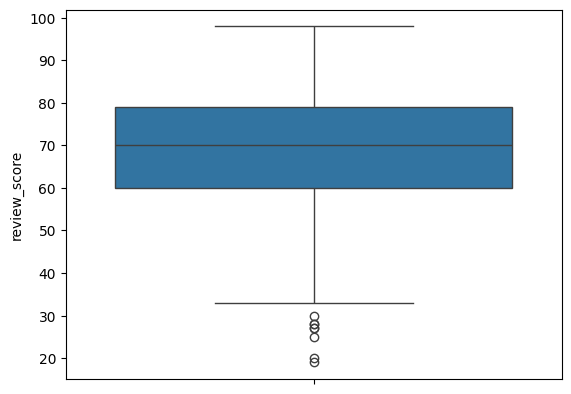

In [7]:
sns.boxplot(df["review_score"])

<Axes: ylabel='sales'>

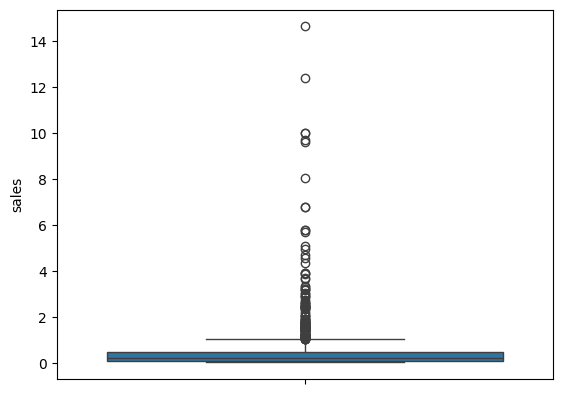

In [8]:
sns.boxplot(df["sales"])

In [9]:
print(len(df[df["sales"] > 10]))
df = df[df["sales"] < 10]

3


<Axes: ylabel='used_price'>

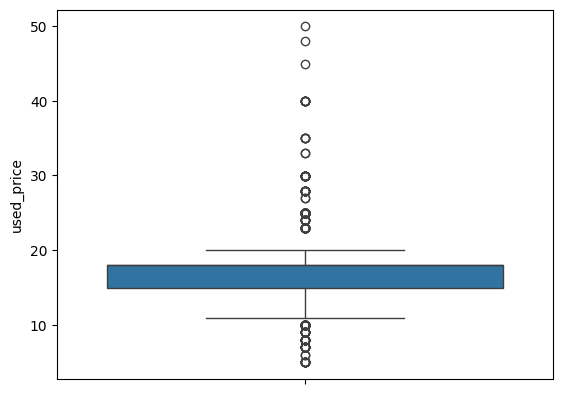

In [10]:
sns.boxplot(df["used_price"])

<Axes: ylabel='average_length'>

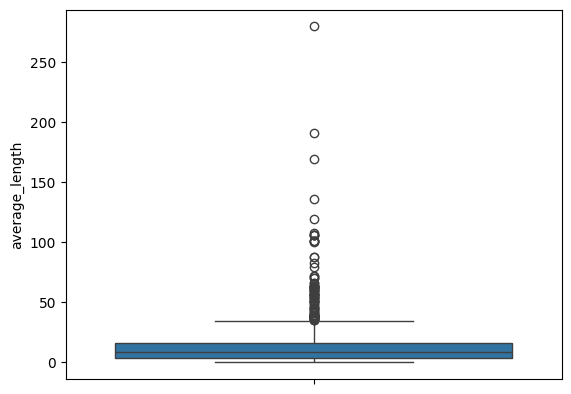

In [11]:
sns.boxplot(df["average_length"])

In [12]:
print(len(df[df["average_length"] > 150]))
df = df[df["average_length"] < 150]

3


<Axes: xlabel='console'>

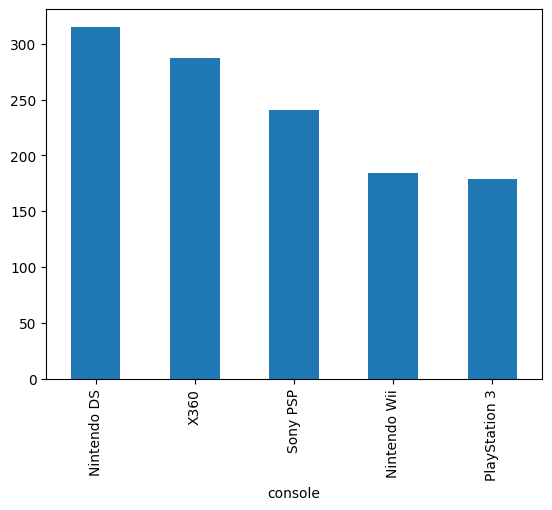

In [13]:
df["console"].value_counts().plot.bar()

<Axes: xlabel='rating'>

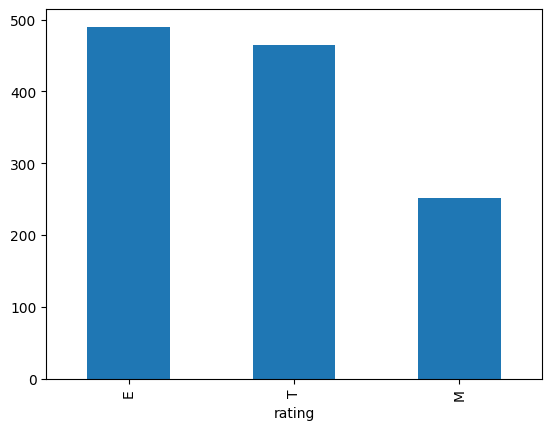

In [14]:
df["rating"].value_counts().plot.bar()

# 4. Preliminary Analysis

### Variable Transformations 

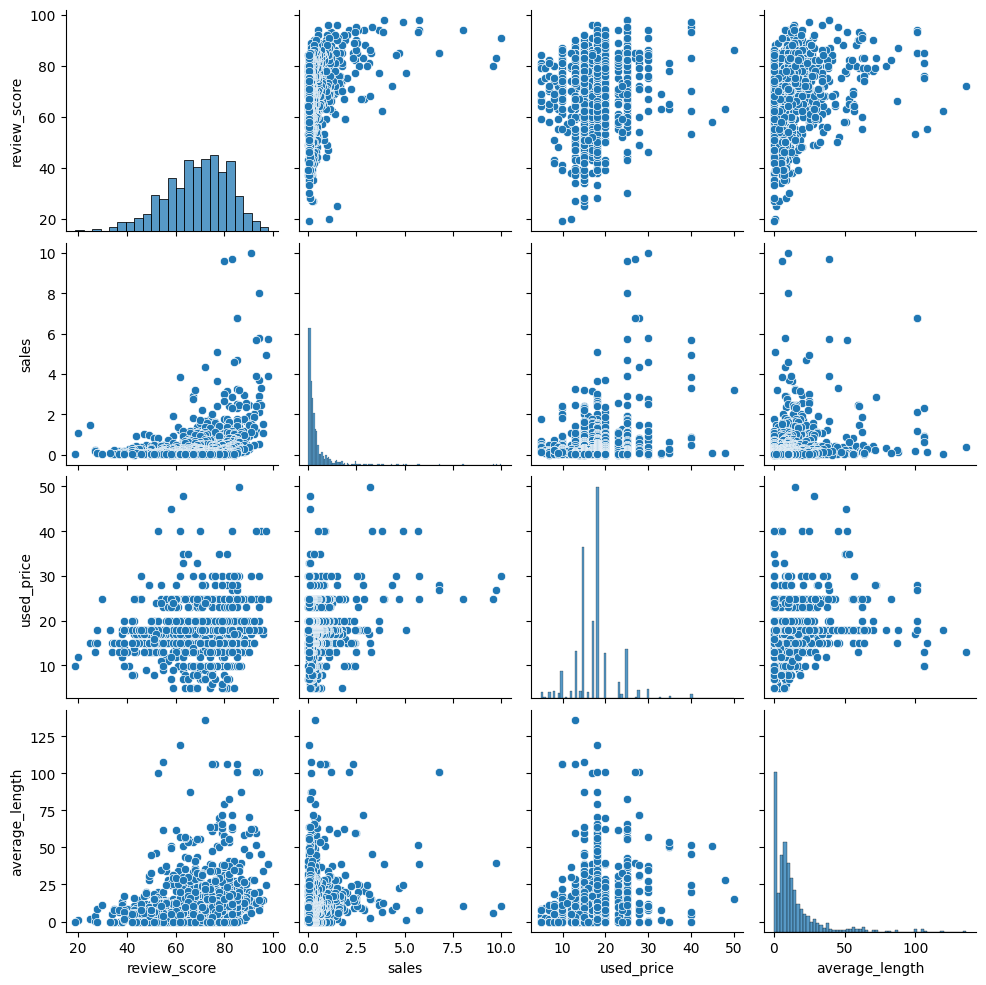

In [15]:
sns.pairplot(df)

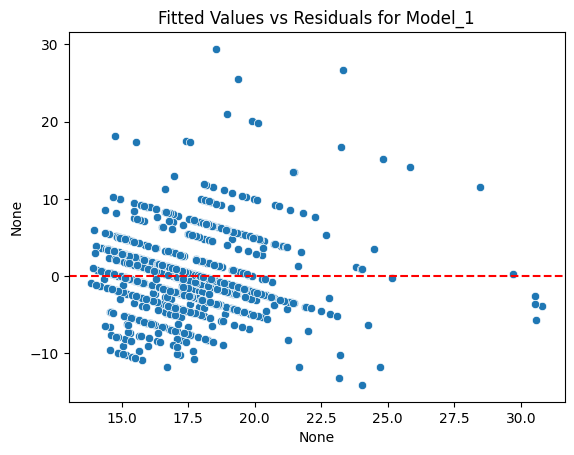

In [16]:
model_1 = smf.ols(formula="used_price~review_score+sales+console+rating+average_length", data=df).fit()
sns.scatterplot(x=model_1.fittedvalues,y=model_1.resid)
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Fitted Values vs Residuals for Model_1")
plt.show()

It looks like the relationship between `used_price` and `sales` could resemble a log curve. In the fitted values vs residuals graph, the linearity assumption appears to be met pretty well, but it fails in a few spots. I will create a new variable that is the log of `sales` called `sales_log` to see if that improves the graph of fitted values vs residuals.

In [17]:
# Create the new transformed variable
df["sales_log"] = np.log(df["sales"])

In the new graph of fitted values vs residuals below, the linearity condition appears to be better met, so I will replace `sales` with the transformed variable `sales_log`.

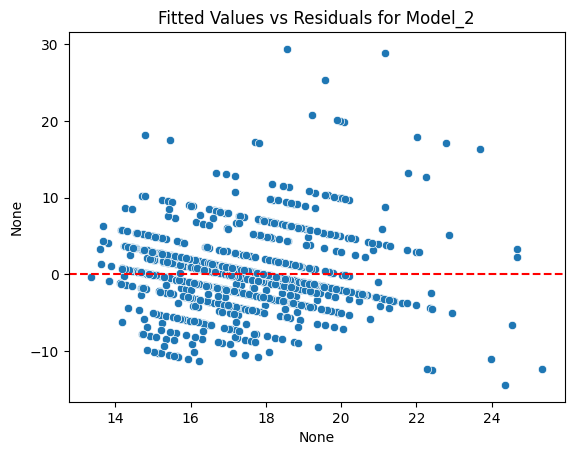

In [18]:
model_2 = smf.ols(formula="used_price~review_score+sales_log+console+rating+average_length", data=df).fit()
sns.scatterplot(x=model_2.fittedvalues,y=model_2.resid)
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Fitted Values vs Residuals for Model_2")
plt.show()

### Interaction Terms 

Based on the following plots showing the relationships between each explanatory variable and the response variable `used_price` while controlling for first `console`, and then `rating`, I've determined that there is an interaction between `review_score` and `console`, `sales` and `console`, and `average_length` and `console`. I came to these determinations because the relationship between the explanatory variable and `used_price` changes based on the different categories of the categorical variable being controlled for, or in other words the slopes are different.

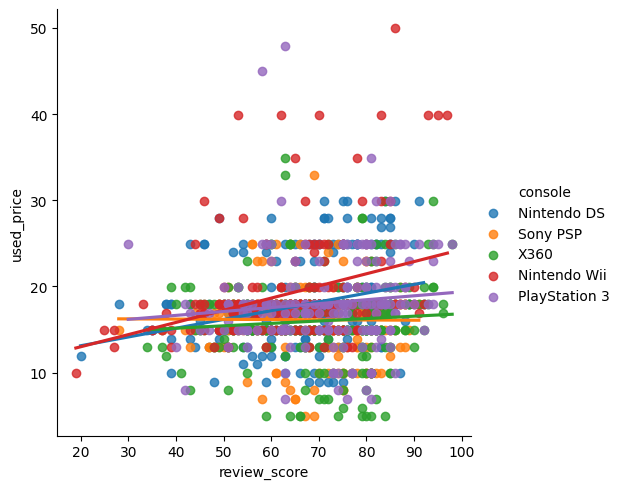

In [19]:
sns.lmplot(x="review_score",y="used_price",hue="console",data=df,ci=False)

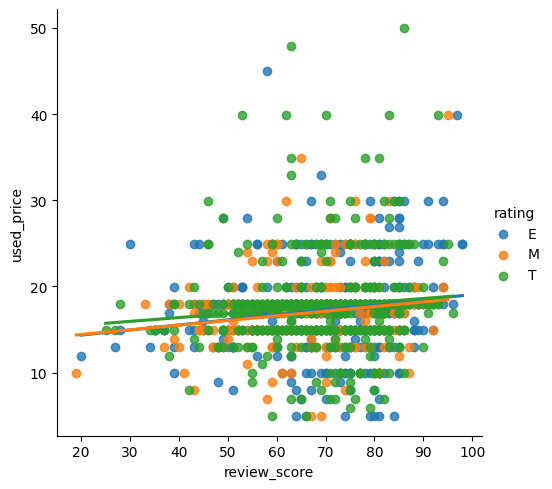

In [20]:
sns.lmplot(x="review_score",y="used_price",hue="rating",data=df,ci=False)

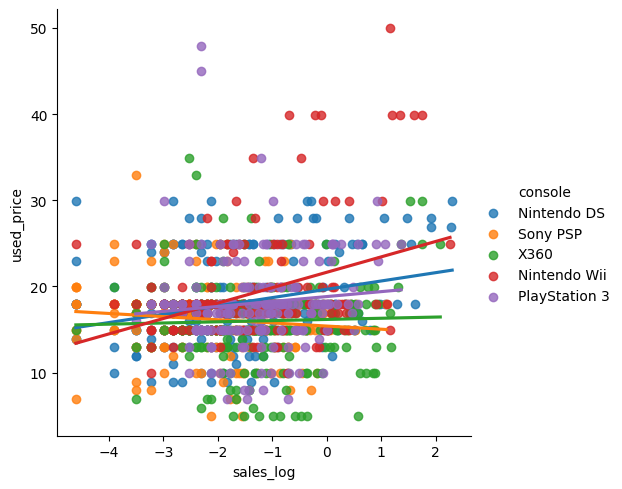

In [21]:
sns.lmplot(x="sales_log",y="used_price",hue="console",data=df,ci=False)

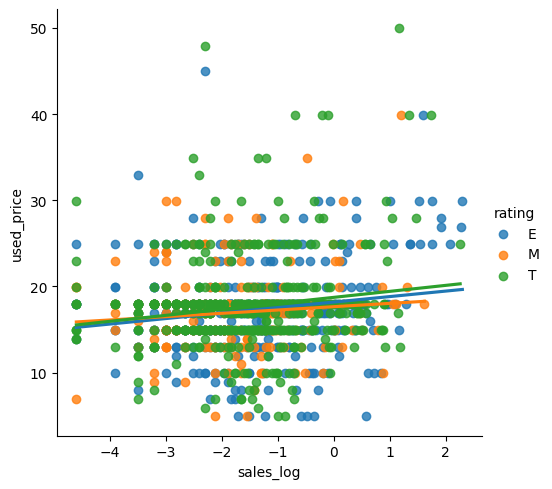

In [22]:
sns.lmplot(x="sales_log",y="used_price",hue="rating",data=df,ci=False)

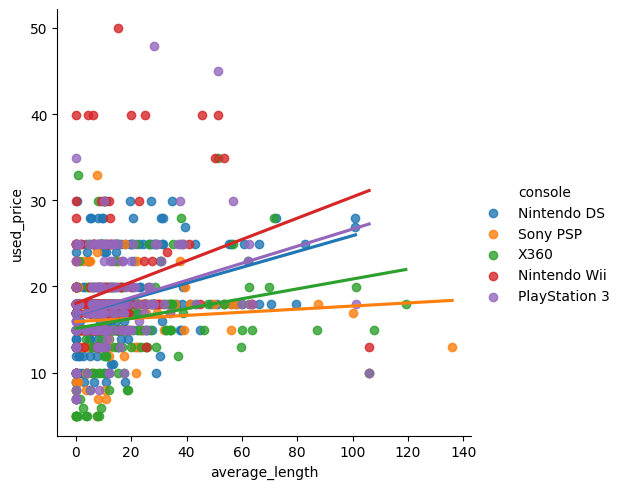

In [23]:
sns.lmplot(x="average_length",y="used_price",hue="console",data=df,ci=False)

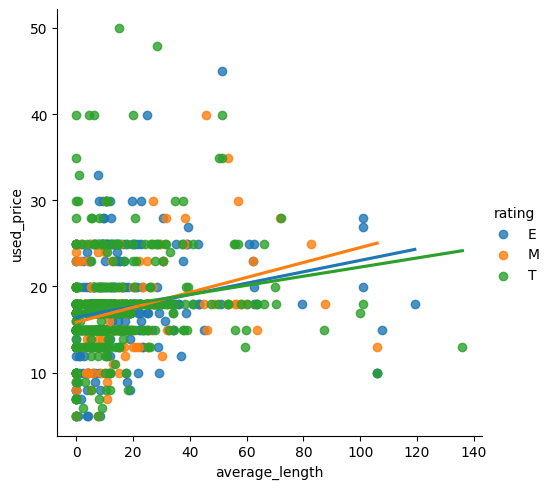

In [24]:
sns.lmplot(x="average_length",y="used_price",hue="rating",data=df,ci=False)

# 5. Predictive Models

### Train-Test-Split

In [25]:
# Perform train-test-split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=207)

### Scaling

In [26]:
scaler = StandardScaler()
scaled_vars = scaler.fit_transform(df_train[["review_score", "average_length", "sales", "sales_log"]])
df_train[["review_score", "average_length", "sales", "sales_log"]] = scaled_vars

In [27]:
scaled_vars = scaler.transform(df_test[["review_score", "average_length", "sales", "sales_log"]])
df_test[["review_score", "average_length", "sales", "sales_log"]] = scaled_vars

## 5.1. Non-Regularized Linear Regression Full Model

Below, I created two non-regularized linear regression models, one with the `sales_log` (transformed variable), and one with `sales` (untransformed variable). Then I calculated the test dataset $R^2$ values. The model using the untransformed variable has a higher $R^2$ value, so moving forward I will discard the transformed variable and stick with the untransformed variable.

In [28]:
# Test model with transformed variable
model_nonreg_1 = smf.ols("used_price~review_score+sales_log+average_length+console+rating",data=df_train).fit()
y_pred = model_nonreg_1.predict(df_test)
print(r2_score(df_test["used_price"], y_pred))

# Test model with untransformed variable
model_nonreg_2 = smf.ols("used_price~review_score+sales+average_length+console+rating",data=df_train).fit()
y_pred = model_nonreg_2.predict(df_test)
print(r2_score(df_test["used_price"], y_pred))

0.0804105610409932
0.11691774552471601


In [29]:
# Discard the transformed variable
df_test.drop("sales_log",axis=1,inplace=True)
df_train.drop("sales_log",axis=1,inplace=True)

## 5.2. Non-Regularized Linear Regression Full Model with Interaction Terms

As noted earlier, there is an interaction between `review_score` and `console`, `sales` and `console`, and `average_length` and `console`. Below, I fit another non-regularized model, but this time I add the interaction terms in. The $R^2$ value is higher than before, which means that the interaction terms increase the predictive power of the model.

In [30]:
model_nonreg_interaction = smf.ols(formula="used_price~review_score+sales+average_length+console+rating+review_score*console+sales*console+average_length*console",data=df_train).fit()
y_pred = model_nonreg_interaction.predict(df_test)
print(r2_score(df_test["used_price"], y_pred))

0.13597431626300405


## 5.3. Feature Selection: Regularization

In this section I created two different regularized models, one using LASSO, and one using Ridge-Regression. For each type, I iterated through at least 100 different evenly spaced lambda values. I display the results for each in line plots below. For the LASSO model, the peak occurred at lambda=0.208 with an $R^2$ value of 0.173279. For the Ridge-Regression model, the peak occurred at lambda=599 with an $R^2$ value of 0.182686.

Additionally, the code is no longer still here, but I think its worth noting that I first performed section 5.3 without incorporating interaction terms. For the LASSO model without interaction terms, the peak occurred at lambda=0.108 with an $R^2$ value of 0.147582. For the Ridge-Regression model without interaction terms, the peak occurred at lambda=131 with an $R^2$ value of 0.147668. The addition of the interaction terms significantly improved the model.

In [31]:
# Create indicator variables
df_with_dummies = pd.get_dummies(df)

# Discard the transformed variable
df_with_dummies.drop("sales_log",axis=1,inplace=True)

# # Create interaction terms
df_with_dummies["review_score*console_Nintendo DS"] = df_with_dummies["review_score"] * df_with_dummies["console_Nintendo DS"]
df_with_dummies["review_score*console_Nintendo Wii"] = df_with_dummies["review_score"] * df_with_dummies["console_Nintendo Wii"]
df_with_dummies["review_score*console_PlayStation 3"] = df_with_dummies["review_score"] * df_with_dummies["console_PlayStation 3"]
df_with_dummies["review_score*console_Sony PSP"] = df_with_dummies["review_score"] * df_with_dummies["console_Sony PSP"]
df_with_dummies["review_score*console_X360"] = df_with_dummies["review_score"] * df_with_dummies["console_X360"]

df_with_dummies["sales*console_Nintendo DS"] = df_with_dummies["sales"] * df_with_dummies["console_Nintendo DS"]
df_with_dummies["sales*console_Nintendo Wii"] = df_with_dummies["sales"] * df_with_dummies["console_Nintendo Wii"]
df_with_dummies["sales*console_PlayStation 3"] = df_with_dummies["sales"] * df_with_dummies["console_PlayStation 3"]
df_with_dummies["sales*console_Sony PSP"] = df_with_dummies["sales"] * df_with_dummies["console_Sony PSP"]
df_with_dummies["sales*console_X360"] = df_with_dummies["sales"] * df_with_dummies["console_X360"]

df_with_dummies["average_length*console_Nintendo DS"] = df_with_dummies["average_length"] * df_with_dummies["console_Nintendo DS"]
df_with_dummies["average_length*console_Nintendo Wii"] = df_with_dummies["average_length"] * df_with_dummies["console_Nintendo Wii"]
df_with_dummies["average_length*console_PlayStation 3"] = df_with_dummies["average_length"] * df_with_dummies["console_PlayStation 3"]
df_with_dummies["average_length*console_Sony PSP"] = df_with_dummies["average_length"] * df_with_dummies["console_Sony PSP"]
df_with_dummies["average_length*console_X360"] = df_with_dummies["average_length"] * df_with_dummies["console_X360"]

# Perform train-test-split
df_train, df_test = train_test_split(df_with_dummies, test_size=0.2, random_state=207)

# Separate features and target matrices
df_train_features = df_train.drop("used_price",axis=1)
df_train_target = df_train["used_price"]

df_test_features = df_test.drop("used_price",axis=1)
df_test_target = df_test["used_price"]

# Scale the feature matrices
scaler = StandardScaler()
cols = ["review_score", "average_length", "sales", "review_score*console_Nintendo DS", "review_score*console_Nintendo Wii", "review_score*console_PlayStation 3",  "review_score*console_Sony PSP", "review_score*console_X360", "sales*console_Nintendo DS", "sales*console_Nintendo Wii", "sales*console_PlayStation 3", "sales*console_Sony PSP", "sales*console_X360", "average_length*console_Nintendo DS", "average_length*console_Nintendo Wii", "average_length*console_PlayStation 3", "average_length*console_Sony PSP", "average_length*console_X360"]
scaled_vars_train = scaler.fit_transform(df_train_features[cols])
df_train_features[cols] = scaled_vars_train
scaled_vars_test = scaler.transform(df_test_features[cols])
df_test_features[cols] = scaled_vars_test

,Lambda,Test R^2
52,0.208,0.173279


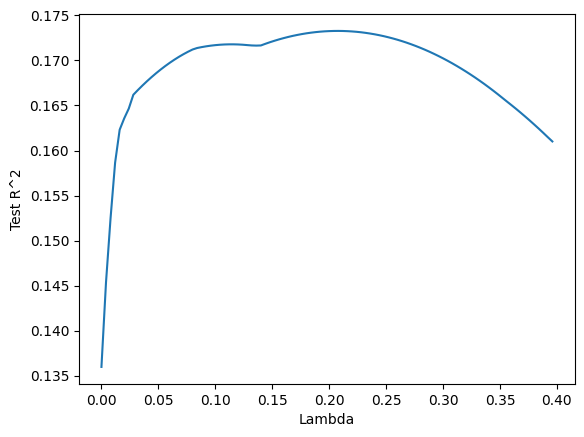

In [32]:
# LASSO Model
data = []
for i in np.arange(0,0.4,0.004):
    temp_model = Lasso(i, max_iter=1000)
    temp_model.fit(df_train_features, df_train_target)
    score = temp_model.score(df_test_features, df_test_target)
    data.append([i, score])
results_lasso = pd.DataFrame(data, columns=['Lambda', "Test R^2"])
plt.plot(results_lasso['Lambda'].values, results_lasso['Test R^2'].values)
plt.xlabel("Lambda")
plt.ylabel("Test R^2")

results_lasso.nlargest(1,"Test R^2")

,Lambda,Test R^2
599,599,0.182686


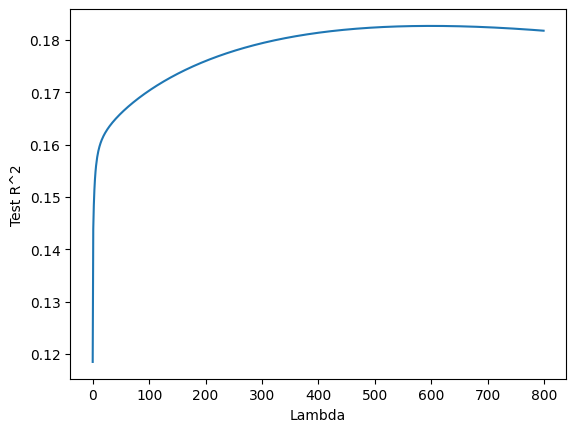

In [33]:
# Ridge Model
data = []
for i in np.arange(0,800,1):
    temp_model = Ridge(i, max_iter=1000)
    temp_model.fit(df_train_features, df_train_target)
    score = temp_model.score(df_test_features, df_test_target)
    data.append([i, score])
results_ridge = pd.DataFrame(data, columns=['Lambda', "Test R^2"])
plt.plot(results_ridge["Lambda"].values, results_ridge["Test R^2"].values)
plt.xlabel("Lambda")
plt.ylabel("Test R^2")

results_ridge.nlargest(1, "Test R^2")

# 6. Best Model Discussion

As stated previously, the LASSO model peaked  at lambda=0.208 with an $R^2$ value of 0.173279 and the Ridge-Regression model peaked at lambda=599 with an $R^2$ value of 0.182686. Below, I look at the slopes for each model. The LASSO model zeroed out 15 (of 26) slopes, and the Ridge-Regression model still has all 26 non-zero slopes. Keeping the secondary research goal in mind, I am going to determine that the best model is the LASSO model. Although the Ridge-Regression model does have a higher $R^2$, its not too much better than the LASSO model. Weighing the pro of a more interpretable model with the con of a slightly lower predictive power, I have come to the conclusion that the LASSO model is the best model.

In [34]:
# Best LASSO Model
best_lasso_model = Lasso(0.208, max_iter=1000)
best_lasso_model.fit(df_train_features, df_train_target)

lasso_slopes = pd.DataFrame({"Slope": best_lasso_model.coef_}, index=df_train_features.columns)
lasso_slopes

,Slope
review_score,0.128374
sales,0.831829
average_length,0.612950
console_Nintendo DS,0.000000
console_Nintendo Wii,0.000000
console_PlayStation 3,0.000000
console_Sony PSP,-0.000000
console_X360,-0.000000
rating_E,0.000000
rating_M,-0.000000


In [35]:
# Best Ridge Model
best_ridge_model = Ridge(473, max_iter=1000)
best_ridge_model.fit(df_train_features, df_train_target)

ridge_slopes = pd.DataFrame({"Slope": best_ridge_model.coef_}, index=df_train_features.columns)
ridge_slopes

,Slope
review_score,0.237147
sales,0.484242
average_length,0.432492
console_Nintendo DS,0.062846
console_Nintendo Wii,0.102749
console_PlayStation 3,0.053403
console_Sony PSP,-0.042183
console_X360,-0.176815
rating_E,0.041535
rating_M,-0.122652


### Equation (Best Lasso Model)

\begin{align*}
\widehat{used\_price} &= 17.396058 \\
&+ 0.128374 \times review\_score \\
&+ 0.831829 \times sales \\
&+ 0.612950 \times average\_length \\
&+ 0.253998 \times review\_score \times console_{Nintendo DS} \\
&+ 0.535757 \times review\_score \times console_{Nintendo Wii} \\
&- 0.097942 \times review\_score \times console_{Sony PSP} \\
&- 0.502593 \times review\_score \times console_{X360} \\
&+ 0.407538 \times sales \times console_{Nintendo Wii} \\
&- 0.168299 \times sales \times console_{Sony PSP} \\
&+ 0.105962 \times average\_length \times console_{Nintendo DS} \\
&+ 0.250389 \times average\_length \times console_{PlayStation 3} \\
\end{align*}

### Test Dataset Fit

The test dataset $R^2$ is 0.173. Objectively, that is not good at all. This means that the model explains 17.3% variability of the response variable. 82.7% of the response variable variability is not explained by the model. This is not very good.

In [36]:
best_lasso_model.score(df_test_features, df_test_target)

0.1732786745242958

### Overfitting Explanatory Variables

The LASSO regularization zeroed out the following explanatory variables: 
* `console_Nintendo DS`, `console_Nintendo Wii`, `console_PlayStation 3`,`console_Sony PSP`, `console_X360`, `rating_E`, `rating_M`, `rating_T`, `review_score*console_PlayStation 3`, `sales*console_Nintendo DS`, `sales*console_PlayStation 3`, `sales*console_X360`, `average_length*console_Nintendo Wii`, `average_length*console_Sony PSP`, `average_length*console_X360`

This means that the two categorical variables `console`, and `rating` were likely overfitting. However, I should note that some of the interaction terms involving `console` were included in the final model.


### Multicollinearity

According to the heatmap below of correlation coefficients, there a a few instances of mild-to-severe multicollinearity.

<Axes: >

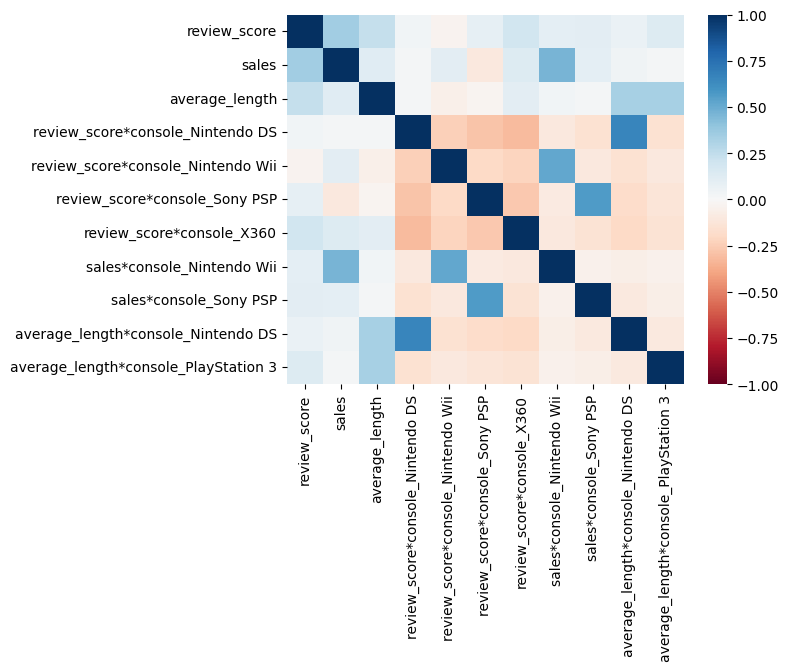

In [47]:
corr = df_train[lasso_slopes[lasso_slopes["Slope"] != 0].index.values].corr()
sns.heatmap(corr,vmin=-1,vmax=1,cmap='RdBu')

### Slope Interpretations

I am able to interpret the magnitudes of the slopes as indicating how important the corresponding explanatory variable is when it comes to predicting the response variable `used_price` in the LASSO linear regression model. This is because the explanatory variables were scaled prior to constructing the model, so that their magnitude would not affect the interpretability of the importance of the variable itself. Based on the slope magnitudes below, the 2 most important explanatoy variables are: `sales` and `average_length`.

In [48]:
lasso_slopes[lasso_slopes["Slope"] != 0]

,Slope
review_score,0.128374
sales,0.831829
average_length,0.612950
review_score*console_Nintendo DS,0.253998
review_score*console_Nintendo Wii,0.535757
review_score*console_Sony PSP,-0.097942
review_score*console_X360,-0.502593
sales*console_Nintendo Wii,0.407538
sales*console_Sony PSP,-0.168299
average_length*console_Nintendo DS,0.105962


# 7. Conclusion

### Recomendation

Ultimately, I would not be able to recommend my final model to a small business owner selling used video games on eBay. My final model does not have enough predictive power and would therefore be unreliable for this person to use.

### Shortcomings/Caveats

I do not know *for sure* that my chosen model will yield the *highest* possible test $R^2$ out of all possible models because it is impractical to test all possible models. A more "complete" analysis would have started will all the original variables in the dataframe and relied on feature selection (not manual selection) to determine which ones to use. A more "complete" analysis would also have tried out more models or different regularization techniques. Another caveat to this analysis is that it does not perform any cross-validations. This could have huge implications for the true predictive power of the model. The best $R^2$ assumed in this analysis may actually be a standard deviation above or below the average $R^2$ that a cross-validation would find.

### Future Work

In future work, I would like to explore more types of models, for example, an elastic-net model. Additionally, I would perform a K-Fold cross-validation in order to be confident in my test $R^2$ value.